# Lab 5: Regularization and Cross-Validation in Python

- **Author:** Prof. Mu-Jeung Yang
- **Version:** October 2018
- **Course:** OAMO 3040: Business Econometrics II

### Learning Objectives:
By the end of the lab, you will be able to:
* Utilize some basice data cleaning techniques
* Run LASSO with different regularlization parameters
* Cross-validate regularlization parameters in LASSO

### References: 
* [Scikit Learn Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso)
* [Scikit Learn Ridge](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
* [Introduction to Statistical Learning, Lab #4](http://www-bcf.usc.edu/~gareth/ISL/Chapter%205%20Lab.txt)
* [Introduction to Statistical Learning, Lab #5](http://www-bcf.usc.edu/~gareth/ISL/Chapter%206%20Lab.txt)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## 1. Data and background

In [2]:
hitters_df = pd.read_csv('data/Hitters.csv', index_col=0)

In [3]:
hitters_df.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [4]:
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
hitters_df.shape

(322, 20)

## 2. Basic data processing

### 2.1 Dropping missing values

In [6]:
pd.isnull(hitters_df['Salary']).value_counts()

False    263
True      59
Name: Salary, dtype: int64

In [7]:
hitters_df = hitters_df.dropna(axis = 0)
hitters_df.shape

(263, 20)

### 2.2 Convert string categories to numercial values

In [8]:
hitters_df.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [9]:
hitters_df.League.value_counts()

A    139
N    124
Name: League, dtype: int64

In [10]:
hitters_df.NewLeague.value_counts()

A    141
N    122
Name: NewLeague, dtype: int64

In [11]:
hitters_df.Division.value_counts()

W    134
E    129
Name: Division, dtype: int64

In [12]:
len(hitters_df)

263

In [13]:
league_dict = {"A":0 ,"N":1}
division_dict = {"E":0, "W":1}

In [14]:
hitters_df.League = hitters_df.League.replace(league_dict)

In [15]:
hitters_df.League.dtype

dtype('int64')

In [16]:
hitters_df.NewLeague = hitters_df.NewLeague.replace(league_dict)
hitters_df.Division = hitters_df.Division.replace(division_dict)

In [17]:
hitters_df.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League         int64
Division       int64
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague      int64
dtype: object

In [18]:
hitters_df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,0.471483,0.509506,290.711027,118.760456,8.593156,535.925882,0.463878
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,0.500138,0.500863,279.934575,145.080577,6.606574,451.118681,0.499644
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000,0.000000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,0.000000,0.000000,113.500000,8.000000,3.000000,190.000000,0.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,0.000000,1.000000,224.000000,45.000000,7.000000,425.000000,0.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,1.000000,1.000000,322.500000,192.000000,13.000000,750.000000,1.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1.000000,1.000000,1377.000000,492.000000,32.000000,2460.000000,1.000000


## 3. Benchmark: OLS

In [19]:
#Step 1: define salary as target variable
salary_df = hitters_df.Salary

#Step 2: extract feature variables / predictors
features_df = hitters_df.drop(['Salary', 'CAtBat', 'CHits', 'CHmRun', 'CRBI', 'CRuns', 'CWalks'], axis=1)

features_df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,League,Division,PutOuts,Assists,Errors,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,1,1,632,43,10,1
-Alvin Davis,479,130,18,66,72,76,3,0,1,880,82,14,0
-Andre Dawson,496,141,20,65,78,37,11,1,0,200,11,3,1
-Andres Galarraga,321,87,10,39,42,30,2,1,0,805,40,4,1
-Alfredo Griffin,594,169,4,74,51,35,11,0,1,282,421,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Willie McGee,497,127,7,65,48,37,5,1,0,325,9,3,1
-Willie Randolph,492,136,5,76,50,94,12,0,0,313,381,20,0
-Wayne Tolleson,475,126,3,61,43,52,6,0,1,37,113,7,0
-Willie Upshaw,573,144,9,85,60,78,8,0,0,1314,131,12,0


#### <font color='blue'>EXCERCISE 1</font>: 
<font color='blue'> a) Using salary as your target variable and the predictors Assists, AtBat, Division, Errors, Hits, HmRun, League, NewLeague, PutOuts, RBI, Runs, Walks and Years, provide a training and a test dataset, where the test dataset should be 34% of the data. For the random number generation, use the random_state=4973. </font>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features_df, salary_df, test_size=0.34, random_state=4973)

<font color='blue'> b) Using salary as your target variable and the predictors Assists, AtBat, Division, Errors, Hits, HmRun, League, NewLeague, PutOuts, RBI, Runs, Walks and Years, train a linear regression model and display the coefficient estimates. </font>

In [21]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
pd.DataFrame(list(zip(features_df, lm.coef_)), columns=['regressor', 'coeff.'])

,regressor,coeff.
0,AtBat,-1.877336
1,Hits,7.195440
2,HmRun,12.079949
3,Runs,1.942465
4,RBI,-2.605630
5,Walks,3.366034
6,Years,31.961232
7,League,12.067674
8,Division,-108.975471
9,PutOuts,0.269320


<font color='blue'> c) Perform an out-of-sample prediction and call it y_pred. What are the values for out-of-sample R-squared and out-of-sample MSE (mean-squared-error)? </font>

In [22]:
y_pred = lm.predict(X_test)
print('Out-of-Sample R-squared:', lm.score(X_test, y_test))
print('Out-of-Sample MSE:', mean_squared_error(y_test, y_pred))

Out-of-Sample R-squared: 0.4168481710837523
Out-of-Sample MSE: 142128.43569612695


<font color='blue'> d) Provide a comparison plot of predicted salary and actual salary. Interpret the comparison plot. </font>

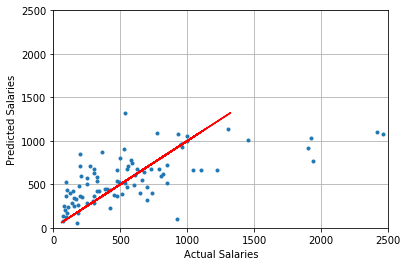

In [23]:
fig, ax = plt.subplots()
ax.plot(y_test, y_pred, '.')
ax.plot(y_pred, y_pred, 'red')
ax.set_xlim(0, 2500)
ax.set_ylim(0, 2500)
ax.set_xlabel('Actual Salaries')
ax.set_ylabel('Predicted Salaries')
ax.grid(True)

## 4. Regularlization with LASSO

In [24]:
from sklearn import linear_model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_df, salary_df, test_size=0.34, random_state=4973)

### 4.1 Unregularlized Lasso

In [26]:
lasso0_model = linear_model.Lasso(alpha = 0)
lasso0_result = lasso0_model.fit(X_train, y_train)
lasso0_result

c:\users\tdmar\qamo-3040\venv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8575835.286552832, tolerance: 3122.959772845715
  positive)


Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [27]:
pd.DataFrame( list(zip(features_df.columns,  lasso0_result.coef_)), columns=['regressor', 'coeff.'])

,regressor,coeff.
0,AtBat,-1.877336
1,Hits,7.195440
2,HmRun,12.079949
3,Runs,1.942465
4,RBI,-2.605630
5,Walks,3.366034
6,Years,31.961232
7,League,12.067674
8,Division,-108.975471
9,PutOuts,0.269320


In [28]:
y_pred_lasso0 = lasso0_result.predict(X_test)
print("Out-of-sample R-squared:", lasso0_result.score(X_test, y_test))

Out-of-sample R-squared: 0.41684817108375116


### 4.2 LASSO with static penalty

In [29]:
lasso10_model = linear_model.Lasso(alpha = 10, fit_intercept=True)
lasso10_result = lasso10_model.fit(X_train, y_train)
lasso10_result

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [30]:
pd.DataFrame( list(zip(features_df.columns,  lasso10_result.coef_)), columns=['regressor', 'coeff.'])

,regressor,coeff.
0,AtBat,-1.922397
1,Hits,7.073504
2,HmRun,9.888869
3,Runs,2.047382
4,RBI,-1.803973
5,Walks,3.450194
6,Years,31.313074
7,League,0.000000
8,Division,-66.825067
9,PutOuts,0.271611


#### <font color='blue'>EXCERCISE 2</font>: 
<font color='blue'> Compute test-sample R-squared of your fitted model with a penalty parameter of alpha=10 and compare this to the performance of the simple OLS regression. What are the differences and how can  you explain them? </font>

In [31]:
print("Out-of-sample R-squared:", lasso10_result.score(X_test, y_test))

Out-of-sample R-squared: 0.41523923192060397


### 4.3 Cross-validated LASSO

#### Cross-validation metrics: k folds

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [33]:
#Set k fold parameters, including number of k folds and randomization
crossv = KFold(n_splits=3, shuffle=True, random_state=4973)

#Set model to be trained and cross validated
Lasso_mod = linear_model.Lasso()

#Calculate scores for lasso
cv_scores = cross_val_score(Lasso_mod, features_df, salary_df,cv = crossv, scoring='r2')

print('LASSO parameters', Lasso_mod)
print('R-sq for each fold are:', cv_scores)
print('Average R-sq, across folds:', np.mean(cv_scores))
print('Std R-sq, across folds:', np.std(cv_scores))

LASSO parameters Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
R-sq for each fold are: [0.41730564 0.28844112 0.32734931]
Average R-sq, across folds: 0.3443653567101154
Std R-sq, across folds: 0.05396712212634575


#### <font color='blue'>EXCERCISE 3</font>: 
<font color='blue'> Interpret the results for the R-squared for the 3 folds we used. Why are the values for this metric changing so much for the different folds? What does that tell you about the reliability of cross-validation? </font>

When we split our data into three different folds, we are decreasing the bias and in turn increasing the variance. R-squared changes because each set of data has different data points so the model does not fit each one equally. Cross validation shows us that we can't rely on our features to accurately predict all salaries.

#### Hyperparameter optimization through cross-validation


In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
#Setting up the grid of possible parameter values for alpha
alpha_range = np.linspace(0.001, 10, 100)

#Defining grid search
gscv_model = GridSearchCV(Lasso_mod, dict(alpha=alpha_range), cv=3, refit=True, scoring='r2')
gscv_result = gscv_model.fit(features_df, salary_df)

#Report results
print(gscv_result.best_estimator_)
print('The optimal penalty parameter is:', gscv_result.best_params_)
print('Cross-validated R-squared:', gscv_result.best_score_)

Lasso(alpha=3.233, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
The optimal penalty parameter is: {'alpha': 3.233}
Cross-validated R-squared: 0.36606097364241574


c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Graphical analysis of hyperparameter optimization

In [36]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
#Generating information from validation_curve command
train_scores, test_scores = validation_curve(Lasso_mod, features_df, salary_df, param_range=alpha_range, param_name="alpha", cv=3, scoring='r2')

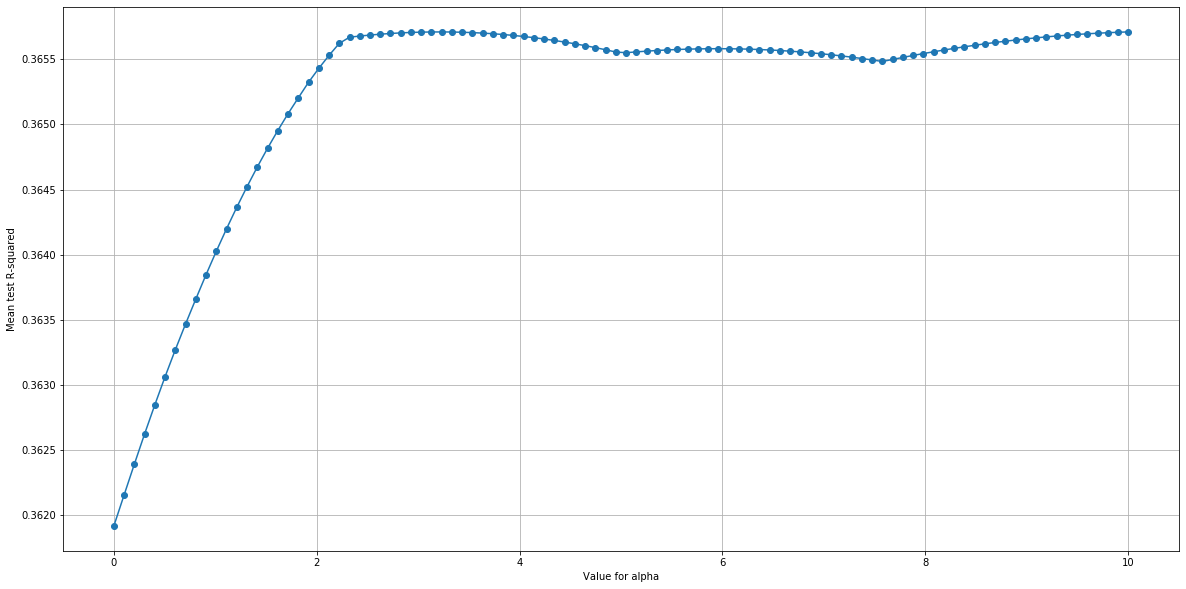

In [38]:
#Outcomes of interest
mean_test = np.mean(test_scores, axis=1)

#plot
plt.figure(figsize=(20,10))
plt.plot(alpha_range, mean_test, 'o-', label="Cross-validation")
plt.grid()
plt.xlabel('Value for alpha')
plt.ylabel('Mean test R-squared')
plt.show()

#### <font color='blue'>EXCERCISE 4</font> 
<font color='blue'> a) Create a feature set that includes the squared terms for all quantitative (non-dummy) variables. Hint: There are two ways to solve this exercise. The first way to code up the square terms individually with numpy. This is a valid approach. The second way is to use for-loops (https://wiki.python.org/moin/ForLoop) in combination with numpy. If you correctly use the for-loops, you will get extra credit. You should have a dataset with 35 variables in the end. </font>

In [39]:
quant_features = hitters_df.drop(columns=['Salary','League', 'Division', 'NewLeague'])
features_df2 = hitters_df.drop(columns=['Salary'])

for col in quant_features:
    features_df2[str(col) + '_sq'] = quant_features[col]**2
    
features_df2



,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,Years_sq,CAtBat_sq,CHits_sq,CHmRun_sq,CRuns_sq,CRBI_sq,CWalks_sq,PutOuts_sq,Assists_sq,Errors_sq
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,...,196,11895601,697225,4761,103041,171396,140625,399424,1849,100
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,...,9,2637376,208849,3969,50176,70756,69169,774400,6724,196
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,...,121,31674384,2480625,50625,685584,702244,125316,40000,121,9
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,...,4,156816,10201,144,2304,2116,1089,648025,1600,16
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,...,121,19430464,1283689,361,251001,112896,37636,79524,177241,625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Willie McGee,497,127,7,65,48,37,5,2703,806,32,...,25,7306209,649636,1024,143641,96721,19044,105625,81,9
-Willie Randolph,492,136,5,76,50,94,12,5511,1511,39,...,144,30371121,2283121,1521,804609,203401,765625,97969,145161,400
-Wayne Tolleson,475,126,3,61,43,52,6,1700,433,7,...,36,2890000,187489,49,47089,8649,21316,1369,12769,49
-Willie Upshaw,573,144,9,85,60,78,8,3198,857,97,...,64,10227204,734449,9409,220900,176400,110224,1726596,17161,144


<font color='blue'> b) Provide a train-test split of the data with 34% of the data in the test set and the random_state=4973. </font>

In [40]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features_df2, salary_df, test_size=0.34, random_state=4973)

<font color='blue'> c) Fit a linear regression model to the training data and compute the test sample R-squared of the trained model. </font>

In [41]:
lm1 = linear_model.LinearRegression()
lm_result1 = lm1.fit(X_train1, y_train1)
print('Out-of-Sample R-squared:', lm_result1.score(X_test1, y_test1))

Out-of-Sample R-squared: 0.6133382235982332


<font color='blue'> d) Show all parameter values of your OLS regression. How many coefficient are zero? </font>

In [42]:
pd.DataFrame( list(zip(features_df2.columns, np.round(lm_result1.coef_,2))), columns=['regressor', 'coeff.'])

,regressor,coeff.
0,AtBat,-0.67
1,Hits,-2.88
2,HmRun,2.00
3,Runs,-0.81
4,RBI,-10.97
5,Walks,-10.01
6,Years,61.51
7,CAtBat,-0.33
8,CHits,1.60
9,CHmRun,2.80


There are 9 features that have coefficients of zero.

<font color='blue'> e) Fit a LASSO model with static penalty of alpha=10 on the training data and provide the test data R-squared of the trained model. How does it compare to OLS? </font>

In [43]:
lasso2_10_model = linear_model.Lasso(alpha=10, fit_intercept=True)
lasso2_10_result = lasso2_10_model.fit(X_train1, y_train1)
print('Out-of-Sample R-squared:', lasso2_10_result.score(X_test1, y_test1))

Out-of-Sample R-squared: 0.6384450471433136


c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4459684.026944535, tolerance: 3122.959772845715
  positive)


R-squared increased by .02 so we correctly predicted an additional 2% of salaries.

<font color='blue'> f) Show all coefficients and count the number of zero coefficients in the LASSO regression. </font>

In [44]:
pd.DataFrame( list(zip(features_df2.columns, np.round(lasso2_10_result.coef_,2))), columns=['regressor', 'coeff.'])

,regressor,coeff.
0,AtBat,-1.04
1,Hits,-2.69
2,HmRun,0.00
3,Runs,-2.12
4,RBI,-8.73
5,Walks,-7.81
6,Years,32.71
7,CAtBat,-0.08
8,CHits,0.85
9,CHmRun,2.40


There are 11 zeros.

<font color='blue'> g) Compare what happened here in exercise 6 when you increased alpha from 0 to 10 to what happened in section 5. How do these two cases differ and what explains the difference? </font>

Increasing alpha got us a higher R-squared value and it set more of the coefficients to zero. By constraining our coefficients, we are allowing the model to fit out-of-sample data better.

<font color='blue'> h) Use a grid search to conduct hyperparamter optimization using cross-validation for the parameter alpha. For this purpose, set up a grid of 100 evenly spaced points for alpha between 0.001 and 10. What is the optimal alpha and what is the value of the cross-validated R-squared? (Note: there might be error messages about alpha values being too small. If you ignore these error message, the code should still give you the correct result. </font>

In [45]:
alpha_range1 = np.linspace(0.001, 10, 100)

#Defining grid search
gscv_model1 = GridSearchCV(lasso2_10_model, dict(alpha=alpha_range1), cv=3, refit=True, scoring='r2')
gscv_result1 = gscv_model1.fit(features_df2, salary_df)

#Report results
print(gscv_result1.best_estimator_)
print('The optimal penalty parameter is:', gscv_result1.best_params_)
print('Cross-validated R-squared:', gscv_result1.best_score_)

train_scores1, test_scores1 = validation_curve(lasso2_10_model, features_df2, salary_df, param_range=alpha_range1, param_name="alpha", cv=3, scoring='r2')

mean_test1 = np.mean(test_scores1, axis=1)


c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4288862.208916941, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4297621.740305755, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3971816.208686271, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4342650.244992175, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4337054.41046233, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4031177.859464405, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4387372.301311578, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4369995.256101363, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4084778.2340876414, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4429367.138861202, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4400343.220157052, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4135032.5371855805, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4177811.115513685, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4468697.121837642, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4428088.561794058, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4502150.5113061685, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4451046.176057199, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4221956.737854055, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4471839.0176847875, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4259302.811645325, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4536413.908631273, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4297267.59846962, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4567980.943297528, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4493910.160717268, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4332161.448573033, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4596944.149670992, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4511996.415240062, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4528381.179736125, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4366885.0487347245, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4625586.716690642, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
The optimal penalty parameter is: {'alpha': 10.0}
Cross-validated R-squared: 0.2313291377780066


c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4305056.874464044, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4310198.668230464, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4315212.281961084, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4465230.782726289, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4468697.121837642, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4472140.898138017, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4586712.034492587, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4589302.185324155, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4591870.823979048, tolerance: 3171.337816088112
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4346293.070390768, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4349330.246191272, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4352346.136223709, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4448847.3913207725, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4451046.176057199, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4453223.375143482, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4519655.912439434, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4521145.427194582, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4522620.615967045, tolerance: 3539.318352553054
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4089485.3853515172, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4094165.255178604, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4098816.9552223966, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4229640.35728611, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4233441.971754062, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4237216.834143152, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4349967.725039523, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4352849.493719123, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4355704.968122829, tolerance: 3943.165545639786
  positive)
c:\users\tdmar\qamo-3040\venv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

<font color='blue'> i) Plot the validation curve, defined as the graph of mean test R-squared across cross-validation folds against different values of alpha. Use as alpha values, the grid you set up in the last problem.</font>

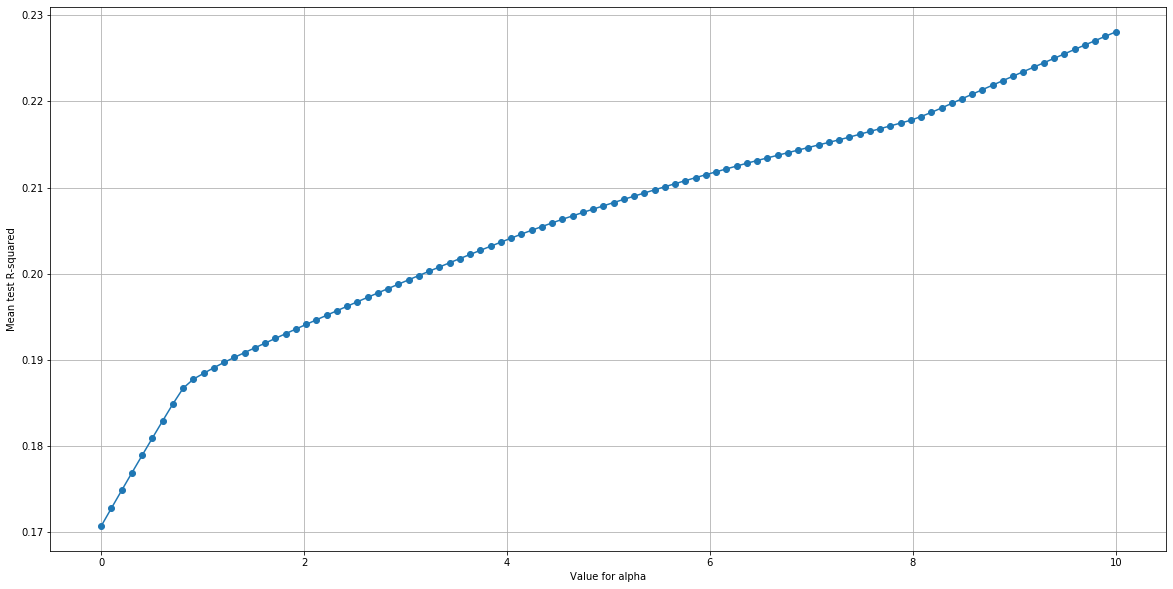

In [46]:
plt.figure(figsize=(20,10))
plt.plot(alpha_range1, mean_test1, 'o-', label="Cross-validation")
plt.grid()
plt.xlabel('Value for alpha')
plt.ylabel('Mean test R-squared')
plt.show()